## Methods


In this notebook, we explore the use of different `methods`. For that, we will
be using `SwissProt` data.


### Setup

---


In [1]:
# Add path to load local modules
import sys

sys.path.insert(0, "..")  # add directory above current directory to path

In [26]:
# ruff: noqa: E402
# Reload modules automatically
%reload_ext autoreload
%autoreload 2

from IPython.display import clear_output
from tqdm import tqdm

# Module imports
import time
import math
from matplotlib import pyplot as plt
import seaborn as sns

# External imports
import numpy as np
import torch
from torch.optim import AdamW
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Custom Modules imports
# - Datasets loading
from datasets.prot.swissprot import SPSimpleDataset, SPSetDataset  # noqa

# - Backbone of for this notebook
from backbones.fcnet import FCNet  # noqa

# - Methods
from methods.baseline import Baseline  # noqa
from methods.protonet import ProtoNet  # noqa
from methods.matchingnet import MatchingNet  # noqa
from methods.maml import MAML  # noqa
from methods.sot import SOT  # noqa

In [3]:
# Set styles
sns.set_style("dark")

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Setup reproducibility
np.random.seed(0)
torch.manual_seed(0)

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Use SOT
USE_SOT = True

### Data Loading

---

In this section, we load the data from the `SwissProt` database which is the
smaller of the two datasets. We will be using both the regular dataloader for
standard few shot finetuning as well as episodic dataloader for episodic
finetuning.

**NB 1:** Evaluation can be done on both types of loaders. However, when it
comes to training, `baseline` method is trained on regular dataloader,
`episodic` method is trained on episodic dataloader.

**NB 2:** what is the correct way of getting samples `get_samples` or
`get_samples_via_ic`?

**NB 3:** We should make sure we all have the same preprocessed dataset since
they they randomly choose the `GO` label for each protein out of all that are on
level 5 if using `get_samples`.


#### Regular Dataloader


In [4]:
# Setup the loading parameters
root = "../data"
batch_size = 10
min_samples = 6

rdata_kwargs = {
    "root": root,
    "batch_size": batch_size,
    "min_samples": min_samples,
}

# Load SPSetDataset for each mode
modes = ["train", "val", "test"]
r_datasets = [SPSimpleDataset(**rdata_kwargs, mode=mode) for mode in modes]
r_train, r_val, r_test = [
    dataset.get_data_loader(num_workers=0, pin_memory=False) for dataset in r_datasets
]

# Get some basic statistics about each of the splits
for split, mode in zip(r_datasets, modes):
    print(f"ℹ️ {mode} split has {len(split)} samples")
    print(f"ℹ️ Each sample is an encoded protein sequence of length {split.dim}")
    print(
        f"ℹ️ {mode} split has {len(np.unique([smp.annot for smp in split.samples]))} classes."
    )
    print()

  EXISTS: go-basic.obo
go-basic.obo: fmt(1.2) rel(2023-06-11) 46,420 Terms; optional_attrs(relationship)
  EXISTS: go-basic.obo
go-basic.obo: fmt(1.2) rel(2023-06-11) 46,420 Terms; optional_attrs(relationship)
  EXISTS: go-basic.obo
go-basic.obo: fmt(1.2) rel(2023-06-11) 46,420 Terms; optional_attrs(relationship)
ℹ️ train split has 11386 samples
ℹ️ Each sample is an encoded protein sequence of length 1280
ℹ️ train split has 155 classes.

ℹ️ val split has 1213 samples
ℹ️ Each sample is an encoded protein sequence of length 1280
ℹ️ val split has 43 classes.

ℹ️ test split has 591 samples
ℹ️ Each sample is an encoded protein sequence of length 1280
ℹ️ test split has 13 classes.



#### Episodic Dataloader


In [78]:
# Setup the loading parameters
root = "../data"
n_way = 2
n_support = 5
n_query = 20
subset = 1.0  # Load full dataset

edata_kwargs = {
    "n_way": n_way,
    "n_support": n_support,
    "n_query": n_query,
    "root": root,
    "subset": subset,
}

# Load SPSetDataset for each mode
modes = ["train", "val", "test"]
e_datasets = [SPSetDataset(**edata_kwargs, mode=mode) for mode in modes]
e_train, e_val, e_test = [
    dataset.get_data_loader(num_workers=0, pin_memory=False) for dataset in e_datasets
]

# Get some basic statistics about each of the splits
for split, mode in zip(e_datasets, modes):
    print(f"ℹ️ {mode} split has {len(split)} number of classes.")
    print(f"ℹ️ Each sample is an encoded protein sequence of length {split.dim}")
    print()

  EXISTS: go-basic.obo
go-basic.obo: fmt(1.2) rel(2023-06-11) 46,420 Terms; optional_attrs(relationship)
  EXISTS: go-basic.obo
go-basic.obo: fmt(1.2) rel(2023-06-11) 46,420 Terms; optional_attrs(relationship)
  EXISTS: go-basic.obo
go-basic.obo: fmt(1.2) rel(2023-06-11) 46,420 Terms; optional_attrs(relationship)
ℹ️ train split has 56 number of classes.
ℹ️ Each sample is an encoded protein sequence of length 1280

ℹ️ val split has 10 number of classes.
ℹ️ Each sample is an encoded protein sequence of length 1280

ℹ️ test split has 2 number of classes.
ℹ️ Each sample is an encoded protein sequence of length 1280



### Backbone choice

---

Before we initiliase our method, we need to choose which backbone we want to
use. Backbone is simply a feature extractor that transforms the raw input
embeddings to a more useful version which can then be later fed into our method
of choice.


To see how the backbone works, we will run it on random batch of our data and
see the output. For the regular dataloader, we can just take the output and feed
it into the backbone as is since it is already in the expected shape.

However, for the episodic dataloader, we obtain a tensor of shape
`(n_way, n_support + n_query, hidden dim)` which we need to remap to
`(n_way * (n_support * n_query), hidden dim)` before feeding it into the
backbone. This is because the backbone expects a tensor of shape
`(batch size, hidden dim)`. Thus, you can think of the mapping as basically
flattening along the second dimension of the input tensor.

**NB:** In the `MetaTemplate` class, and specifically its `parse_feature`
method, the flattening is performed as:

```python
x = x.view(n_way * (n_support + n_query), *x.size()[2:])
```

This makes indeed only sense if we for instance have more than 1 last dimension,
e.g. the input tensor would be `(n_way, n_support + n_query, seq, hidden dim)`.
Based on the [eda notebook](eda.ipynb), we know that the input tensor is of
shape `(n_way, n_support + n_query, hidden dim)` and thus we can simply flatten
along the second dimension as:

```python
x = x.view(n_way * (n_support + n_query), -1)
```

With that being said, for the purpose of generalisation, we can keep the
original code. TODO: discuss


In [79]:
# Sample a batch from the regular train loader
r_seq, r_lab = next(iter(r_train))
print(f"ℹ️ r_batch has {len(r_seq)} samples each with dim {r_seq.shape[1]}")

# Sample a batch from the episodic train loader
e_seq, e_lab = next(iter(e_train))
n_way, n_support, n_query = (
    edata_kwargs["n_way"],
    edata_kwargs["n_support"],
    edata_kwargs["n_query"],
)
e_seq = e_seq.contiguous().view(n_way * (n_support + n_query), -1)
print(f"ℹ️ e_batch has {e_seq.shape[0]} samples each with dim {e_seq.shape[1]}")

ℹ️ r_batch has 10 samples each with dim 1280
ℹ️ e_batch has 50 samples each with dim 1280


On a high level, we have three main modules that include different variations of
backbones. The purpose of this notebook is on exploring the different methods
and thus we will not go into details of the backbones. Instead, see the
dedicated [backbones notebook](backbones.ipynb) for more details.

In this notebook, we will use `FCNet`, a simple fully connected network where we
can choose its depth as well as number of hidden units in each layer. Finally,
each layer automatically includes `BatchNorm1d`, a `ReLU` activation function
and a `Dropout` layer for which we can define the probability.


In [80]:
# Setup the backbone parameters
fcnet_kwargs = {
    "x_dim": 1280,
    "layer_dim": [512, 256, 128],
    "dropout": 0.1,
    "fast_weight": False,
}
output_dim = fcnet_kwargs["layer_dim"][-1]

backbone = FCNet(**fcnet_kwargs).to(device)

# Run the backbone on the random batch
r_out = backbone(r_seq.to(device))
assert (
    r_out.shape[0] == r_seq.shape[0]
), "❌ r_out should have same number of samples as r_seq"
print(f"✅ r_out and r_seq have same number of samples")
assert (
    r_out.shape[1] == output_dim
), f"❌ r_out should have dim {output_dim} as last dim, instead got {r_out.shape[1]}"
print(f"✅ r_out has dim {output_dim} as last dim as expected")

# Run the backbone on the encoded batch
e_out = backbone(e_seq.to(device))
assert (
    e_out.shape[0] == e_seq.shape[0]
), "❌ e_out should have same number of samples as e_seq"
print(f"✅ e_out and e_seq have same number of samples")
assert (
    e_out.shape[1] == output_dim
), f"❌ e_out should have dim {output_dim} as last dim, instead got {e_out.shape[1]}"
print(f"✅ e_out has dim {output_dim} as last dim as expected")

✅ r_out and r_seq have same number of samples
✅ r_out has dim 128 as last dim as expected
✅ e_out and e_seq have same number of samples
✅ e_out has dim 128 as last dim as expected


### SOT

---


TODO: adde description here.


In [81]:
if USE_SOT:
    sot = SOT(
        # Cause of transductive setting
        final_feat_dim=n_way * (n_support + n_query),
        distance_metric="cosine",
        or_reg=0.1,
        sinkhorn_iterations=10,
        sigmoid=False,
        mask_diag=True,
        max_scale=True,
    )
else:
    sot = None

### MetaTemplate

---

The `MetaTemplate` class serves as a base class for all the methods. It includes
all the necessary methods that are needed for training and evaluation. The main
methods are:

- `forward`: this method runs backbone on the raw input embeddings. Before
  calling this method, make sure the feature the input is in the correct format
  by running `parse_featue` method.

- `train_loop`: this method runs `set_forward_loss` (**must be implemented by
  the child**) method on the training data and updates the model parameters
  based on the loss.

- `test_loop`: this method evaluates the model on the test data. It calls the
  `set_forward` method (**must be implemented by the child**) to obtain the
  predictions and then calculates the overall accuracy, i.e., total number of
  correct predictions accross all classes divided by the total number of
  predictions.

- `set_forward_adaptation`: this method first splits the input test data into
  support and query sets. Then, it freezes the backbone, and finetunes a new
  softmax classifier on the support set. Finally, it returns the predictions on
  the query set. Therefore, the difference between the `test_loop` and
  `set_forward_adaptation` is that the former does not conduct any finetuning,
  while the latter does. NB: Have not seen this method being used anywhere yet.

See more details in the [meta-template module](../methods/meta_template.py).


### Baseline (++)

---

The baseline training and evaluation can be splitted into two parts:

(I) **BackBone Pretraining:** In the very first step, we pretrain the backbone
on the entire training dataset. We compute the loss on the given task
(classification / regression) and then update the weights of the backbone.

(II) **Finetuning:** We finetune the backbone on the support set of each class
or for regression, we just finetune on the entire support set. Note that
finetuning is done on the given "test set", i.e., either `validation` or `test`
set. Once we are done with finetuning, we make predictions on the query set and
compute the corresponding accuracy using `MetaTemplate`'s `correct` method.

Both of these parts are visualised in the following figure:

![baseline](../images/baseline_overview.png)

Importantly, we differentiate between two types of classifiers in the
pretraining step:

- **Linear Classifier:** Standard Linear layer.

- **Cosine Classifier:** Cosine similarity between the embedding and the weight
  embeddings for individual classes.

Let's start with the **pretraining**.


In [16]:
# Define the target dim which is the number of unique classes in the dataset
target_dim = len(r_datasets[0].trg2idx)
print(f"ℹ️ Target dim is {target_dim}")

# Define baseline parameters
baseline_kwargs = {
    "backbone": backbone,
    "n_way": n_way,  # For finetuning part only
    "n_support": n_support,  # For fine-tuning part only
    # Defines the output dim of the head, important for pretraining the backbone
    "n_classes": target_dim,
    "loss": "softmax",  # baseline uses 'softmax', baseline++ uses 'dist'
    "type": "classification",
    "log_wandb": False,
    "print_freq": 100,  # Print every 100 batches
    "sot": sot,
}


# Define the baseline model
baseline = Baseline(**baseline_kwargs).to(device)

# Define training hyperparameters
n_epochs = 10
lr = 0.001

# Define the optimizer for obtaining training
optimizer = AdamW(baseline.parameters(), lr=lr)

# Train the baseline model
for epoch in range(n_epochs):
    baseline.train_loop(epoch, r_train, optimizer)

ℹ️ Target dim is 10351


Training: Epoch 001 | Batch/ Episode 1100/1107 | Loss 3.47053: 100%|██████████████████████████████| 1107/1107
Training: Epoch 002 | Batch/ Episode 1100/1107 | Loss 2.33116: 100%|██████████████████████████████| 1107/1107
Training: Epoch 003 | Batch/ Episode 1100/1107 | Loss 1.99339: 100%|██████████████████████████████| 1107/1107
Training: Epoch 004 | Batch/ Episode 1100/1107 | Loss 1.73656: 100%|██████████████████████████████| 1107/1107
Training: Epoch 005 | Batch/ Episode 1100/1107 | Loss 1.57570: 100%|██████████████████████████████| 1107/1107
Training: Epoch 006 | Batch/ Episode 1100/1107 | Loss 1.45618: 100%|██████████████████████████████| 1107/1107
Training: Epoch 007 | Batch/ Episode 1100/1107 | Loss 1.34925: 100%|██████████████████████████████| 1107/1107
Training: Epoch 008 | Batch/ Episode 1100/1107 | Loss 1.26115: 100%|██████████████████████████████| 1107/1107
Training: Epoch 009 | Batch/ Episode 1100/1107 | Loss 1.19319: 100%|██████████████████████████████| 1107/1107
Training: 

Now, we can move on to the **finetuning**. Notice, that here instead of the
regular dataloader, we use the episodic dataloader which alows us to finetune
the support set and then make predictions on the query set. These predictions
are then used to compute the accuracy.


In [17]:
eval_acc = baseline.test_loop(e_val, return_std=True)
clear_output()
print(f"ℹ️ The validation accuracy is {eval_acc[0]:.2f} ± {eval_acc[1]:.2f}")

ℹ️ The validation accuracy is 60.80 ± 16.50


### Prototypical Networks

---

We train the protonet using the **meta-learning framework**. In each epoch, we
now instead of classical batches have episodes. Each episode consists of a
support set and a query set for each class. The support set is used to compute
the prototypes for each class. Then, we compute the similarity between the query
set and the prototypes and use the class with the largest similarity as the
prediction. As of now, as a measure of similarity we use negative distanc, i.e.,
the smaller the distance the bigger the similarity. Finally, we compute the loss
based on the query set predictions and update the model parameters.

For the **evaluation**, we split the data into support and query sets. Then, we
compute the prototypes on the support set and use them to make predictions on
the query set. Finally, we compute the accuracy based on the predictions.

![protonet](../images/protonet_overview.png)

**NB:** Notice that in both baseline and ProtoNet we use some of the validation
set. In case of baseline, we use it to finetune the classifier, while in
ProtoNet we use it to compute the prototypes. However, for the protonet, or any
other model trained via meta learning, we could, for the inference phase,
finetune specific classifier to make the predictions. In other words, we use the
meta learning framework for obtaining optimal weights for the backbone.


In [84]:
# Define protonet kwargs
protonet_kwargs = {
    "backbone": backbone,
    "n_way": n_way,
    "n_support": n_support,
    "sot": sot,
}

# Define the ProtoNet Model
protonet = ProtoNet(**protonet_kwargs).to(device)


# Define training hyperparameters
n_epochs = 2
lr = 1e-4

# Define the optimizer for obtaining training
optimizer = AdamW(protonet.parameters(), lr=lr)

# Train the protonet model
for epoch in range(n_epochs):
    protonet.train_loop(epoch, e_train, optimizer)

Training: Epoch 001 | Episode 1018/1018 | Loss 0.47905: 100%|██████████████████████████████| 1018/1018
Training: Epoch 002 | Episode 1018/1018 | Loss 0.43880: 100%|██████████████████████████████| 1018/1018


Next, we evaluate the protonet as desribed above, i.e., we compute the
prototypes on the support set and use them to make predictions on the query set.
Finally, we compute the accuracy based on the predictions. This is done for
several episodes which each consists of a random selection of classses.


In [87]:
eval_acc = protonet.test_loop(e_val)
clear_output()
print(f"ℹ️ The validation accuracy is {eval_acc[0]:.2f} ± {eval_acc[1]:.2f}")

ℹ️ The validation accuracy is 80.56 ± 2.79


### Matching Networks

---

The matching network **training** can be splitted into two parts:

(I) **Encode support embeddings:** we run the support set embeddings first via
the backbone and then via the encoder. In our case, this is a
**bidirectional-LSTM**. In particular, we take the outpout of both directions
which each has the `feat_dim`, i.e., the same as the output of the backbone, and
then add it to the output of the backbone. Thus, we can see this as sort of
residual connection.

(II) **Compute weighted sum of query embeddings:** We take the query embeddings
and recompute their transformation via a single LSTM cell that uses an attention
mechanism.

(III) **Compute the logprobs:** In our final step, we take the output of the
first and second step and compute the similarity between the support and query
embeddings. This is done via a dot product between the support and query
embeddings matrices. We then take the softmax, so that we obtain the probability
distribution for each query embedding with respect to each support embedding. We
then sum the probabilities for each class and take the log of the sum. This is
our final output.

![matchingnet](../images/matchingnet_overview.png)

For the inference, we do the same as for the training, except that we do not
update the model parameters and just return the logprobs for each query
embedding.


In [22]:
# Define matchingnet kwargs
matchingnet_kwargs = {
    "backbone": backbone,
    "n_way": n_way,
    "n_support": n_support,
    "sot": sot,
}

# Define the MatchingNet Model
matchingnet = MatchingNet(**matchingnet_kwargs).to(device)

# Define training hyperparameters
n_epochs = 1
lr = 1e-4

# Define the optimizer for obtaining training
optimizer = AdamW(matchingnet.parameters(), lr=lr)

# Train the protonet model
for epoch in range(n_epochs):
    matchingnet.train_loop(epoch, e_train, optimizer)

Training: Epoch 001 | Episode 0444/0444 | Loss 1.57713: 100%|██████████████████████████████| 444/444


So now we can evaluate as with any other method before using the `test_loop`
method.


In [23]:
eval_acc = matchingnet.test_loop(e_val)
clear_output()
print(f"ℹ️ The validation accuracy is {eval_acc[0]:.2f} ± {eval_acc[1]:.2f}")

ℹ️ The validation accuracy is 87.02 ± 2.00


We are getting huge performance boost when using the `SOT` layer. Let's train the model again and collect the embeddings for the support and query sets.

In [30]:
# Define matchingnet kwargs
matchingnet_kwargs = {
    "backbone": backbone,
    "n_way": n_way,
    "n_support": n_support,
    "sot": sot,
}

# Define the MatchingNet Model
matchingnet = MatchingNet(**matchingnet_kwargs).to(device)

# Define training hyperparameters
n_epochs = 1
lr = 1e-4

# Define the optimizer for obtaining training
optimizer = AdamW(matchingnet.parameters(), lr=lr)
epochs_info = []
for epoch in range(n_epochs):

    # Run one epoch of episodic training
    num_episodes = len(e_train)
    pbar = matchingnet.get_progress_bar(enumerate(e_train), total=num_episodes)
    pbar.set_description(
        f"Training: Epoch {epoch:03d} | Episodes 000/{num_episodes:03d} | 0.0000"
    )
    loss = 0.0
    embeddings = []
    ep_losses = []
    query_labels = []
    for i, (x, _) in pbar:
        # Set the number of query samples and classes
        matchingnet.set_nquery(x)
        if matchingnet.change_way:
            matchingnet.set_nway(x)

        # Run one iteration of the optimization process
        optimizer.zero_grad()

        # Get the query labels
        y_query = matchingnet.get_episode_labels(matchingnet.n_query, enable_grad=True)
        query_labels.append(y_query)

        # Compute the scores (logprobs)
        scores, emb = matchingnet.set_forward(x, return_emb=True)
        embeddings.append(emb)

        # Compute the negative log likelihood loss
        episode_loss = matchingnet.loss_fn(scores, y_query)

        episode_loss.backward()
        optimizer.step()

        # Add batch loss to total loss
        loss += episode_loss.item()
        ep_losses.append(loss / (i + 1))

        # Print the loss
        matchingnet.log_training_progress(pbar, epoch, i, num_episodes, loss)

    # Compute the epoch loss as average of the episode losses
    epoch_loss = loss / num_episodes
    epochs_info.append({"epoch_loss": loss, "embeddings": embeddings, "query_labels": query_labels, "episode_losses": ep_losses})

Training: Epoch 001 | Episode 0444/0444 | Loss 1.37471: 100%|██████████████████████████████| 444/444


Let's now visualise the collected embeddings, specifically if we can see that their separation is getting better episode after episode.

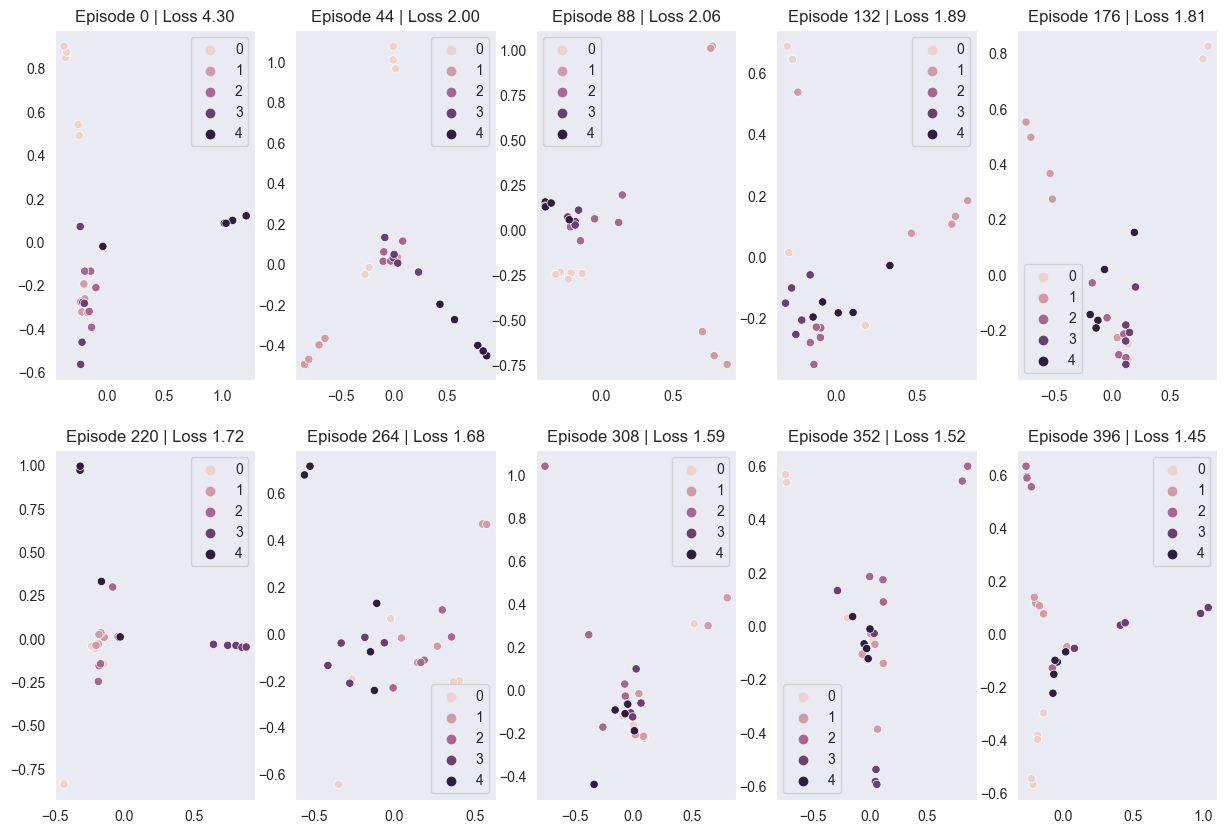

In [70]:
# Choose epoch to inspect
epoch = 0

# Get the embeddings for the epoch
epoch_info = epochs_info[epoch]

# Get the embeddings for the epoch
embeddings = epoch_info["embeddings"]

# Get the query labels for the epoch
query_labels = epoch_info["query_labels"]

# Get the losses
ep_losses = epoch_info["episode_losses"]

# Split into support and query
support, query = [emb[0] for emb in embeddings], [emb[1] for emb in embeddings]

# Get number of episodes
num_episodes = len(support)

# Compute the step size if we want to visualize every X episodes
num_episodes_viz = 10
step_size = num_episodes // num_episodes_viz

# Iterate over the episodes, use tsne to visualize the embeddings
ax_index = 0
fig, axs = plt.subplots(2, 5, figsize=(15, 10))
for i in range(len(axs)):
    for j in range(len(axs[0])):
        # Get the query embeddings
        index = min(ax_index * step_size, num_episodes - 1)
        q = query[index].detach().cpu().numpy()
        labels = query_labels[index].detach().cpu().numpy()
        loss = ep_losses[index]

        # Compute the reduced embeddings
        # tsne_emb = TSNE(n_components=2, perplexity=10).fit_transform(q)
        reduced_emb = PCA(n_components=2).fit_transform(q)

        # Plot the tsne embedding
        ax = axs[i, j]
        sns.scatterplot(x=reduced_emb[:, 0], y=reduced_emb[:, 1], hue=labels, ax=ax)
        ax.set_title(f"Episode {index} | Loss {loss:.2f}")
        ax_index += 1

From the above plot, we can clerly see that the model is capable of learning the embeddings that are well separated. This is also reflected in the loss which is decreasing with each episode. Let's see the embeddings for the test set.

In [61]:
# Collect the accuracy for each episode
episodes_results = []

ep = 0
for x, y in tqdm(e_val, desc="Evaluating"):
    # Set the number of query samples and classes
    matchingnet.set_nquery(x)
    if matchingnet.change_way:
        matchingnet.set_nway(x)

    # Get ground truth along with mapping from index to encoding
    query_meta = matchingnet.get_episode_labels(matchingnet.n_query, enable_grad=False).cpu().numpy()
    y_true = y[:, matchingnet.n_support :]
    unq = torch.unique(y_true, dim=1).cpu().numpy()[:, 0]
    idx2encoding = {idx: encoding for idx, encoding in enumerate(unq)}
    y_true = y_true.reshape(matchingnet.n_way * matchingnet.n_query).cpu().numpy()

    # Get predictions and map them from index to encoding
    scores, emb = matchingnet.set_forward(x, return_emb=True)
    _, topk_labels = scores.data.topk(k=1, dim=1, largest=True, sorted=True)
    y_meta = topk_labels.cpu().numpy()[:, 0]
    y_pred = np.array([idx2encoding[idx] for idx in y_meta])

    # Compute accuracy
    acc = np.mean(y_true == y_pred)

    # Save to evals
    episodes_results.append({"embeddings": emb, "y_true": y_true, "y_pred": y_pred, "acc": acc, "query_meta": query_meta, "ep" : ep})
    ep += 1

Evaluating: 100%|██████████| 45/45 [00:00<00:00, 79.29it/s]


In [62]:
mean_acc = np.mean([ep["acc"] for ep in episodes_results])
median_acc = np.median([ep["acc"] for ep in episodes_results])
print(f"ℹ️ The mean val accuracy is {mean_acc:.2f}")
print(f"ℹ️ The median val accuracy is {median_acc:.2f}")

ℹ️ The mean val accuracy is 0.82
ℹ️ The median val accuracy is 0.84


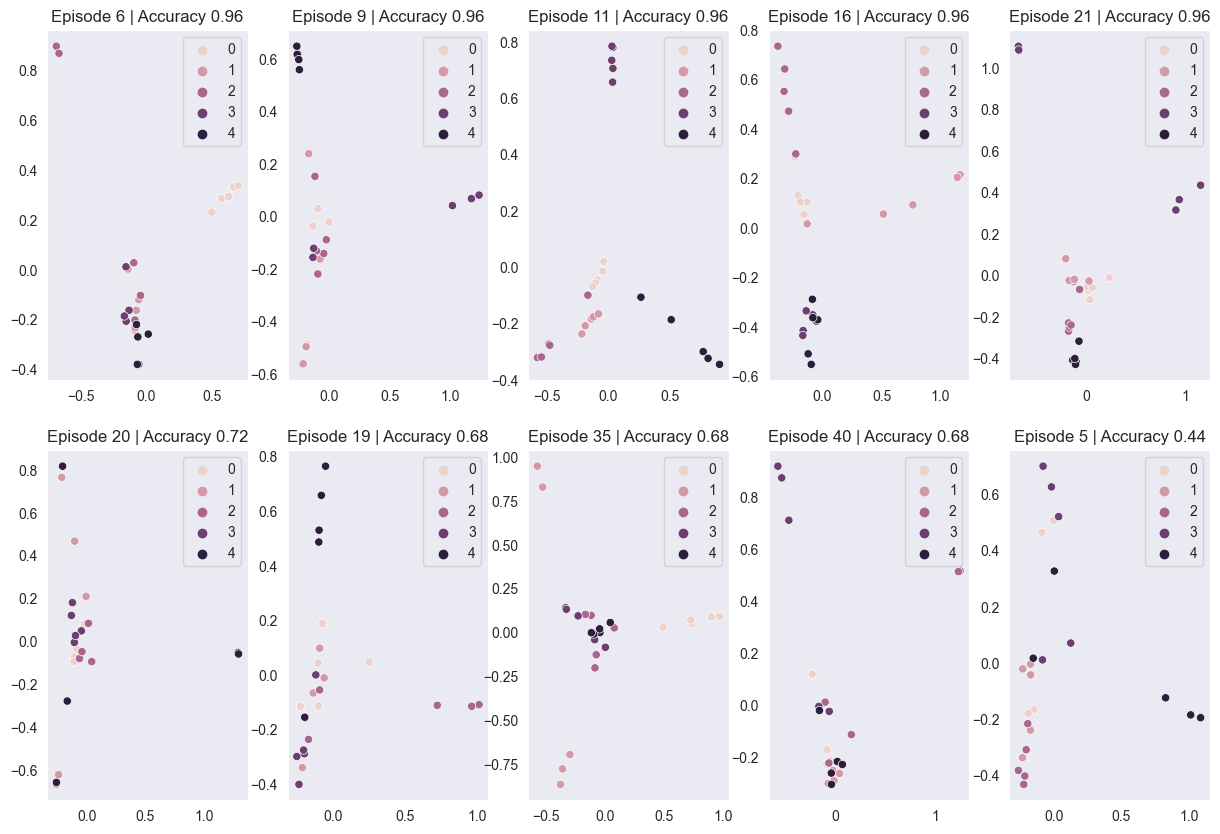

In [69]:
 # Sort the results by accuracy
episodes_results = sorted(episodes_results, key=lambda k: k["acc"], reverse=True)

# Get the best 5 and wors 5 episodes
best_episodes = episodes_results[:5]
worst_episodes = episodes_results[-5:]

# Merge together the episodes in this order
episodes = best_episodes + worst_episodes

# Iterate over the episodes, use tsne to visualize the embeddings
fig, axs = plt.subplots(2, 5, figsize=(15, 10))
index = 0
for i in range(len(axs)):
    for j in range(len(axs[0])):

        # Get the data for the episode
        q = episodes[index]["embeddings"][1].detach().cpu().numpy()
        labels = episodes[index]["query_meta"]
        acc = episodes[index]["acc"]
        ep = episodes[index]["ep"]

        # Compute the reduced embeddings
        # tsne_emb = TSNE(n_components=2, perplexity=10).fit_transform(q)
        reduced_emb = PCA(n_components=2).fit_transform(q)

        # Plot the tsne embedding
        ax = axs[i, j]
        sns.scatterplot(x=reduced_emb[:, 0], y=reduced_emb[:, 1], hue=labels, ax=ax)
        ax.set_title(f"Episode {ep} | Accuracy {acc:.2f}")
        index += 1

### Model-Agnostic Meta-Learning (MAML)

---

The key idea behind **MAML** is to train a model on a variety of tasks to learn
an optimal initial set of parameters from which it will be easy after a few
gradient steps to finetune to a new task. In other words, we want to learn a
good initialization of the model parameters such that we can quickly adapt to a
new task with a few gradient steps.

The **meta-training** procedure can be described as follows. Our model, in this
case backbone as well as the classifier are intiliased as usual with random
weights, in the MAML setting, we call these **slow weights**. In each epoch, we
then sample a batch of episodes where each epidode essentially represents a
task. In particular each episode is represtented as a tensor of shape
`(n_way, n_support + n_query, hidden_dim)`. Now, for each task, we first split
the data into support and query sets as usual. Then, we initialise our fast
weights from the slow weights. We then compute the loss on the support set and
update the fast weights. We do this for a given number of steps, e.g., 5.
Finally, we compute the loss on the query set. We do this for every epidode and
then compute the sum of episode losses. This is our final loss which we use to
update the slow weights. We then continue to another batch of episodes and
repeat the same procedure.

![maml](../images/maml_overview.png)

For the **meta-testing** part, we do not update the slow weights. Instead, for
now only **each episode**, we initialise the fast weights from the slow weights
for and then compute the loss on the support set. We repeat this for a given
number of steps and finally make the predictions on the query set. We then
compute the accuracy based on the predictions. We then take the mean of the
accuracies across all episodes.


In [9]:
# Setup the backbone parameters
maml_backbone_kwargs = {
    "x_dim": 1280,
    "layer_dim": [512, 256, 128],
    "dropout": 0.1,
    "fast_weight": True,  # Use fast weights for MAML!
}

maml_backbone = FCNet(**maml_backbone_kwargs).to(device)

# Define maml kwargs
maml_kwargs = {
    "backbone": maml_backbone,
    "n_way": n_way,
    "n_support": n_support,
    "n_task": 4,  # After how many tasks to update the meta-learner
    "task_update_num": 3,  # Number of gradient updates per task
    "inner_lr": 1e-2,  # Learning rate for the fast weight
    "log_wandb": False,
    "print_freq": 1,  # Print every X episodes
    "sot": sot,
}

# Define the Maml Model
maml = MAML(**maml_kwargs).to(device)

# Define training hyperparameters
n_epochs = 10
lr = 1e-3

# Define the optimizer for obtaining training
optimizer = AdamW(maml.parameters(), lr=lr)

# Train the protonet model
for epoch in range(n_epochs):
    maml.train_loop(epoch, e_train, optimizer)

Training: Epoch 001 | Batch/ Episode 0100/0100 | Loss 1.63380:   0%|                              | 0/100
Training: Epoch 002 | Batch/ Episode 0100/0100 | Loss 1.57195:   0%|                              | 0/100
Training: Epoch 003 | Batch/ Episode 0100/0100 | Loss 1.50864:   0%|                              | 0/100
Training: Epoch 004 | Batch/ Episode 0100/0100 | Loss 1.44870:   0%|                              | 0/100
Training: Epoch 005 | Batch/ Episode 0100/0100 | Loss 1.37819:   0%|                              | 0/100
Training: Epoch 006 | Batch/ Episode 0100/0100 | Loss 1.30860:   0%|                              | 0/100
Training: Epoch 007 | Batch/ Episode 0100/0100 | Loss 1.24736:   0%|                              | 0/100
Training: Epoch 008 | Batch/ Episode 0100/0100 | Loss 1.18154:   0%|                              | 0/100
Training: Epoch 009 | Batch/ Episode 0100/0100 | Loss 1.12875:   0%|                              | 0/100
Training: Epoch 010 | Batch/ Episode 0100/0100

Finally, we can evaluate the model by adapting the model to the support set for
the `task_update_num` and then making predictions on the query set:


In [10]:
eval_acc = maml.test_loop(e_val, return_std=True)
clear_output()
print(f"ℹ️ The validation accuracy is {eval_acc[0]:.2f} ± {eval_acc[1]:.2f}")

ℹ️ The validation accuracy is 95.27 ± 6.06


---
